In [98]:
  !pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#IMPORTING STATEMENTS

In [261]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [262]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [307]:
data_flag = 'pneumoniamnist'
download = True

n_epochs = 5
BATCH_SIZE = 128
lr = 0.04
momentum = 0.5
batch_size_train = 6
batch_size_test = 1000
log_interval=10

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

#PREPROCESSING

In [308]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

#LOAD THE DATA

In [309]:
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='test',transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


#ENCAPSULATE DATA INTO DATALOADER FORM

In [310]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [311]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(val_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 624
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of

#VISUALIZING TRANING DATASET

In [312]:
import matplotlib.pyplot as plt

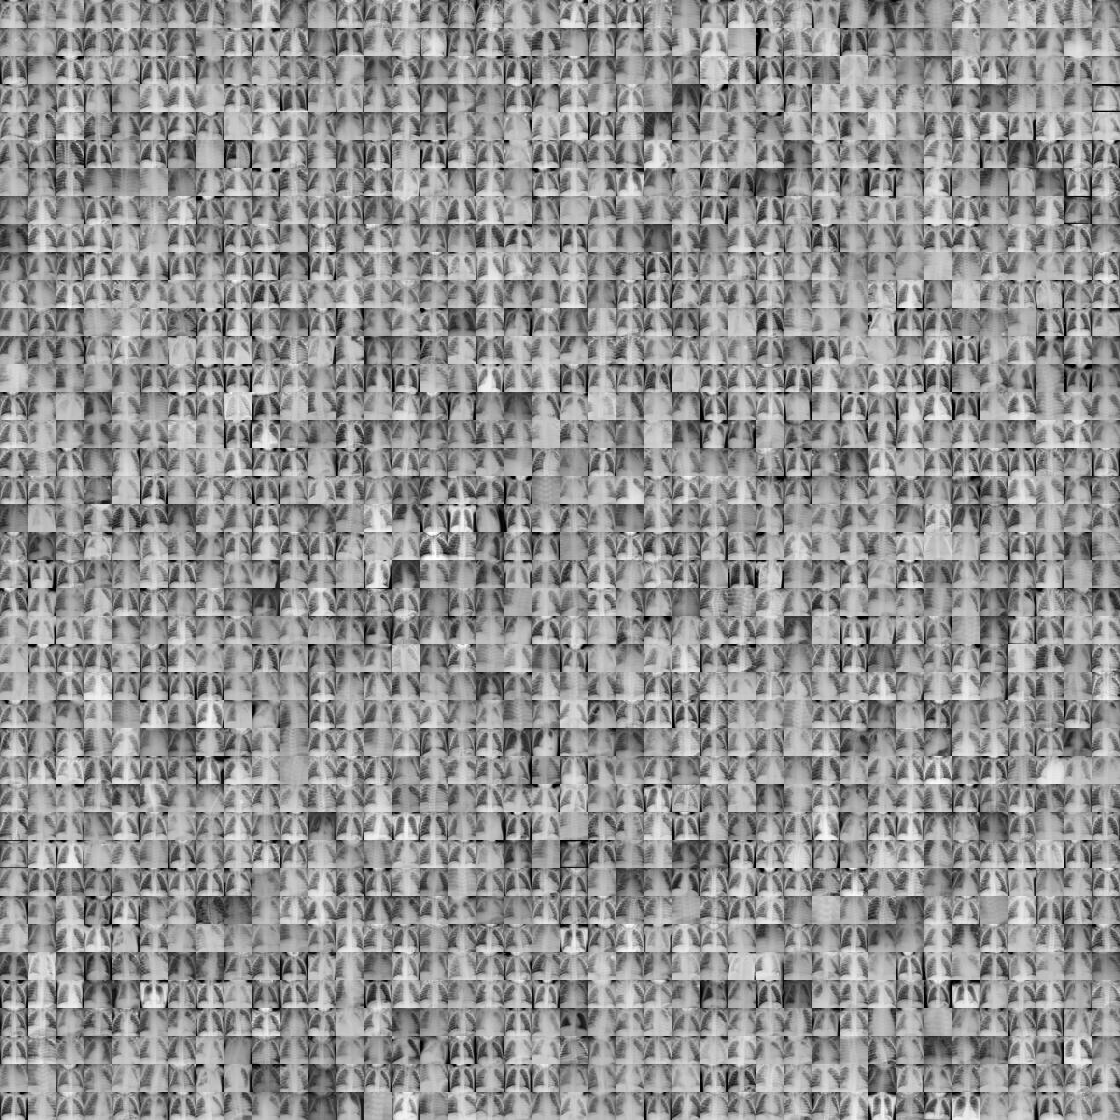

In [313]:
train_dataset.montage(length=40)

#VISUALIZING TESTING DATASET

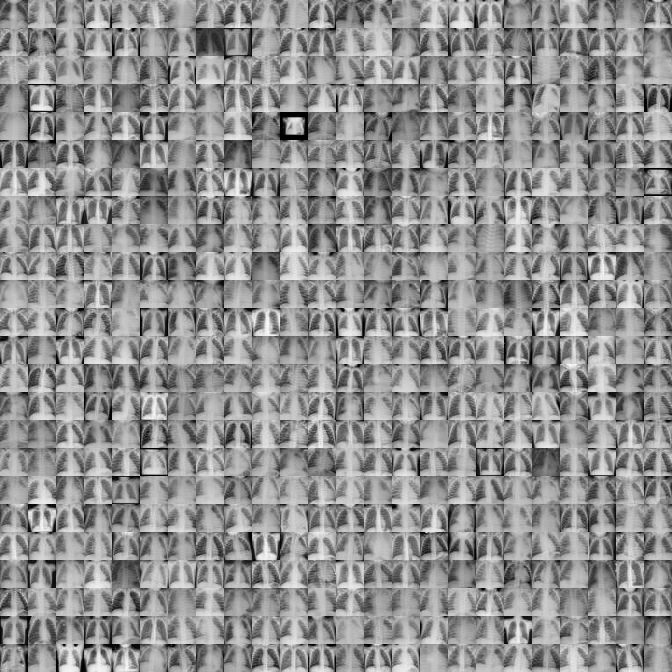

In [314]:
test_dataset.montage(length=24)

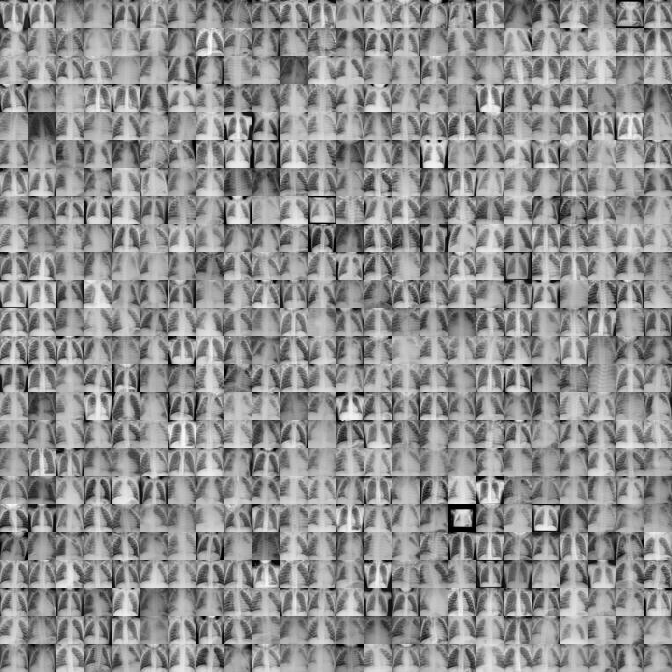

In [315]:
val_dataset.montage(length=24)

#ARCHITECTURE

In [316]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [317]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

##SELECTING SGD OPTIMIZER

In [318]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=lr,
                      momentum=momentum)

#TRAINING AND VALIDATION

##TRAIN AND TEST LOADER

In [319]:
import torch
import torchvision

In [320]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [321]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

##TRAINING

In [322]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

##TESTING

In [323]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [324]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-317-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Streaming output truncated to the last 5000 lines.
Train Epoch: 1 [900/60000 (2%)]	Loss: 1.665474
Train Epoch: 1 [960/60000 (2%)]	Loss: 1.743816
Train Epoch: 1 [1020/60000 (2%)]	Loss: 2.036654
Train Epoch: 1 [1080/60000 (2%)]	Loss: 1.475361
Train Epoch: 1 [1140/60000 (2%)]	Loss: 1.789216
Train Epoch: 1 [1200/60000 (2%)]	Loss: 1.347031
Train Epoch: 1 [1260/60000 (2%)]	Loss: 2.025779
Train Epoch: 1 [1320/60000 (2%)]	Loss: 1.296270
Train Epoch: 1 [1380/60000 (2%)]	Loss: 1.224854
Train Epoch: 1 [1440/60000 (2%)]	Loss: 0.781503
Train Epoch: 1 [1500/60000 (2%)]	Loss: 0.875914
Train Epoch: 1 [1560/60000 (3%)]	Loss: 0.584914
Train Epoch: 1 [1620/60000 (3%)]	Loss: 0.903686
Train Epoch: 1 [1680/60000 (3%)]	Loss: 1.766955
Train Epoch: 1 [1740/60000 (3%)]	Loss: 1.867385
Train Epoch: 1 [1800/60000 (3%)]	Loss: 1.121352
Train Epoch: 1 [1860/60000 (3%)]	Loss: 0.951998
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.357990
Train Epoch: 1 [1980/60000 (3%)]	Loss: 1.971660
Train Epoch: 1 [2040/60000 (3%)]	Loss: 

#EVALUATION OF MODEL PERFORMANCE

In [281]:
import matplotlib.pyplot as plt

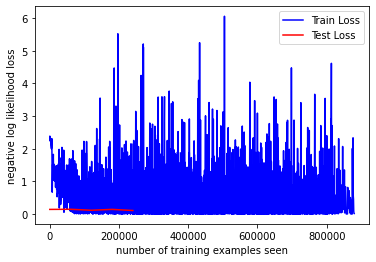

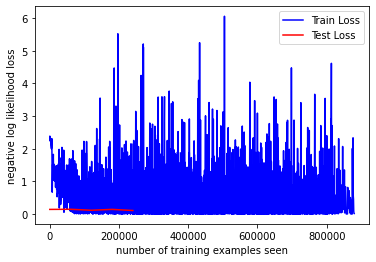

In [282]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

##SELECTING ADAM OPTIMIZER

In [283]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=lr)

In [284]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [285]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [286]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-273-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Streaming output truncated to the last 5000 lines.
Train Epoch: 1 [900/60000 (2%)]	Loss: 2.354720
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.367299
Train Epoch: 1 [1020/60000 (2%)]	Loss: 2.330733
Train Epoch: 1 [1080/60000 (2%)]	Loss: 2.301983
Train Epoch: 1 [1140/60000 (2%)]	Loss: 2.185660
Train Epoch: 1 [1200/60000 (2%)]	Loss: 2.267349
Train Epoch: 1 [1260/60000 (2%)]	Loss: 2.367953
Train Epoch: 1 [1320/60000 (2%)]	Loss: 2.365757
Train Epoch: 1 [1380/60000 (2%)]	Loss: 2.345404
Train Epoch: 1 [1440/60000 (2%)]	Loss: 2.295985
Train Epoch: 1 [1500/60000 (2%)]	Loss: 2.253259
Train Epoch: 1 [1560/60000 (3%)]	Loss: 2.282110
Train Epoch: 1 [1620/60000 (3%)]	Loss: 2.335253
Train Epoch: 1 [1680/60000 (3%)]	Loss: 2.344371
Train Epoch: 1 [1740/60000 (3%)]	Loss: 2.251858
Train Epoch: 1 [1800/60000 (3%)]	Loss: 2.256093
Train Epoch: 1 [1860/60000 (3%)]	Loss: 2.268538
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.391308
Train Epoch: 1 [1980/60000 (3%)]	Loss: 2.344853
Train Epoch: 1 [2040/60000 (3%)]	Loss: 